<a href="https://colab.research.google.com/github/SebastianEcheverryL/Machine-Learning-InceptionV3-with-Tensorflow/blob/main/ProjectDSPInceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INCEPTIONV3 MODEL

The first step was to download and import the libraries that are necessary to realize the InceptionV3 model. In this case we don't create a directory inside Drive, but we manage directly the GitHub address where the data is hosted, this by Kaggle's recommendation.

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Input
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import kagglehub
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix
import sklearn.metrics as skm
import seaborn as sns

In [ ]:
# Download latest version
path = kagglehub.dataset_download("rizwan123456789/potato-disease-leaf-datasetpld")
path_base = path + '/PLD_3_Classes_256'
path_train = path_base + '/Training'
path_val = path_base + '/Validation'
path_test = path_base + '/Testing'

Next, the ImageDataCreator function is used to perform a digital preprocessing of the images in order to ensure correct machine learning. First the image is divided by 255 to normalize it and ensure that the value of each pixel is between 0-1.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

Next, the parameters of the image generators are configured. The direction where the generator will take the images is configured. The number of images per batch, the training generator has more images per batch, because the number of images is higher. Also a resizing of 150x150 is done, this in order to reduce the computational cost, but it cannot be reduced much because the quality of the images worsens a lot. And we choose the mode used by the generator, in this case as we have 3 classes we must use a categorical mode.

In [ ]:
train_generator = train_datagen.flow_from_directory(
        path_train, # the directory where the training images are located
        target_size=(150, 150), # resize all images to 150x150
        batch_size=50, # Number of images per batch
        class_mode='categorical' # Classification for multiple classes
)

test_generator = test_datagen.flow_from_directory(
        path_test, # the directory where the test images are located
        target_size=(150, 150), # Resize all images to 150x150
        batch_size=10, # Number of images per batch
        class_mode='categorical' # Classification for multiple classes
)

validation_generator = validation_datagen.flow_from_directory(
        path_val, # the directory where the validation images are located
        target_size=(150, 150), # Resize all the images to 150x150
        batch_size=10, # Number of images per batch
        class_mode='categorical' # Classification for multiple classes
)

Found 3251 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 416 images belonging to 3 classes.


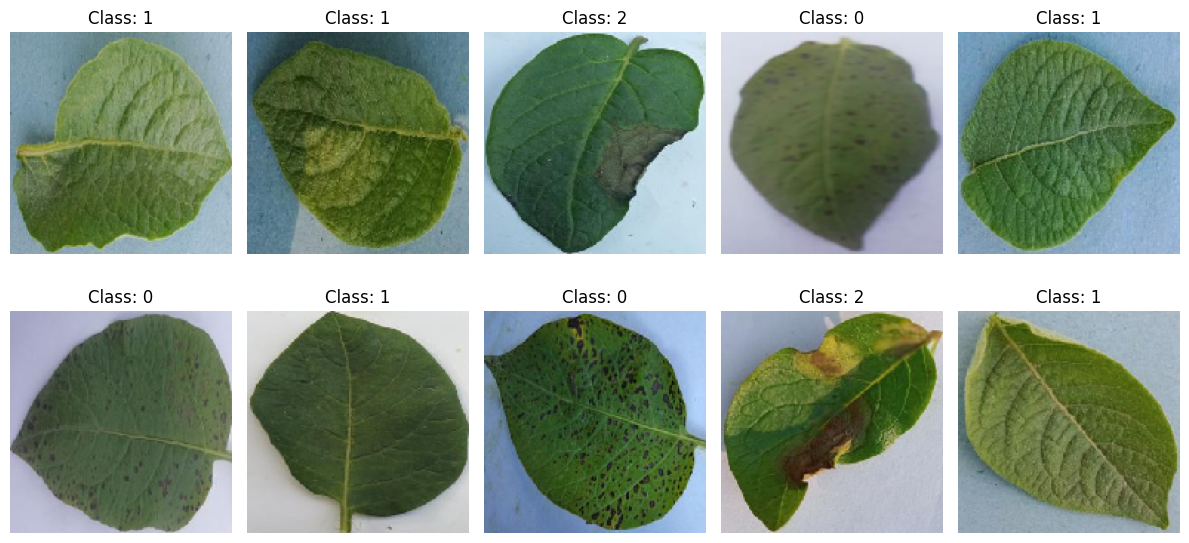

In [ ]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Display the images in the batch
fig, axes = plt.subplots(2, 5, figsize=(12, 6)) # Create a 2x4 grid
axes = axes.flatten()

for img, label, ax in zip(images, labels, axes):
    ax.imshow(img) # Show the image.
    ax.axis('off') # Remove the axes
    ax.set_title(f"Class: {label.argmax()}") # Show class label

plt.tight_layout()
plt.show()

Unlike the CNN model, in this case we do not design a convolutional network from scratch, but we start from the one designed by InceptionV3 . InceptionV3 is a learning model designed for 1000 classes, so in this case we must use the code line “include_top = False”, to remove the neural network for 1000 classes and design one for 3 classes. Also as we want to perform a transfer learning to save computational resources we must use a value of false in the parameter “trainable”. The neural network is designed the same in all models to make comparisons between the three models.

In [ ]:
# Load the pre-trained InceptionV3 model into ImageNet, without including the top layers.
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False # Freeze pretrained layers
base_model.summary()

# Define sequential model with InceptionV3 as basis
model_InceptionV3 = keras.Sequential([
    keras.Input(shape=(150, 150, 3)),  # Define the input explicitly
    base_model, # Add base model as first layer
    keras.layers.Flatten(), # Vectorization
    keras.layers.Dense(256, activation='relu'), # Fully connected layer with 256 neurons and ReLU activation
    keras.layers.Dropout(0.5), # Dropout layer for preventing overfitting
    keras.layers.Dense(3, activation='softmax'), # Output layer with softmax for multiclass classification
])

# Print summary of the complete model
model_InceptionV3.summary() # Print a summary of the model architecture

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_376 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_376   │ (None, 74, 74, 32)     │             96 │ conv2d_376[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_376            │ (None, 74, 74, 32)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_377 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_376[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_377   │ (None, 72, 72, 32)     │             96 │ conv2d_377[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_377            │ (None, 72, 72, 32)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_378 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_377[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_378   │ (None, 72, 72, 64)     │            192 │ conv2d_378[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_378            │ (None, 72, 72, 64)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 35, 35, 64)     │              0 │ activation_378[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_379 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_379   │ (None, 35, 35, 80)     │            240 │ conv2d_379[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_379            │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_380 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,522,403 (101.17 MB)

 Trainable params: 4,719,619 (18.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In this section 3 different processes are carried out: Compilation, Training and Evaluation.
In the compilation stage it is defined which optimizer will be used, which type of mode will be used depending on the number of classes and the desired metrics.
In the training stage, the images generated by the training generator are entered and validated with the test images.
Finally, the learning of the model is evaluated with the validation set.

In [ ]:
model_InceptionV3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model_InceptionV3.fit(train_generator, epochs=25, validation_data=test_generator)

test_loss, test_acc = model_InceptionV3.evaluate(validation_generator, steps=len(validation_generator))
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 209ms/step - accuracy: 0.6337 - loss: 3.6634 - val_accuracy: 0.8889 - val_loss: 0.3196
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8582 - loss: 0.3790 - val_accuracy: 0.9037 - val_loss: 0.2708
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8869 - loss: 0.2979 - val_accuracy: 0.8765 - val_loss: 0.2830
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9032 - loss: 0.2670 - val_accuracy: 0.9136 - val_loss: 0.2455
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9047 - loss: 0.2740 - val_accuracy: 0.9012 - val_loss: 0.2519
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9154 - loss: 0.2295 - val_accuracy: 0.8988 - val_loss: 0.2649
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9088 - loss: 0.2302 - val_accuracy: 0.9358 - val_loss: 0.2081
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9116 - loss: 0.2174 - val_accuracy: 0.8840 -

Losses and accuracy are evaluated by time. Twenty-five epochs were chosen because it presents the best learning with less time and computational resources.

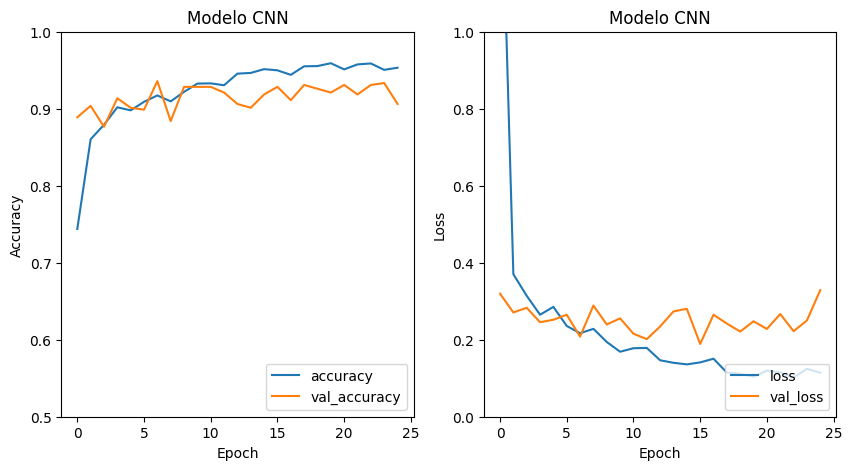

In [ ]:
# The learning curves of the CNN model are calculated and plotted:

plt.figure(figsize=(10,5))

#Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Modelo CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Modelo CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

Finally, the confusion matrix and the accuracy and recall report are performed by predicting the model.

26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step


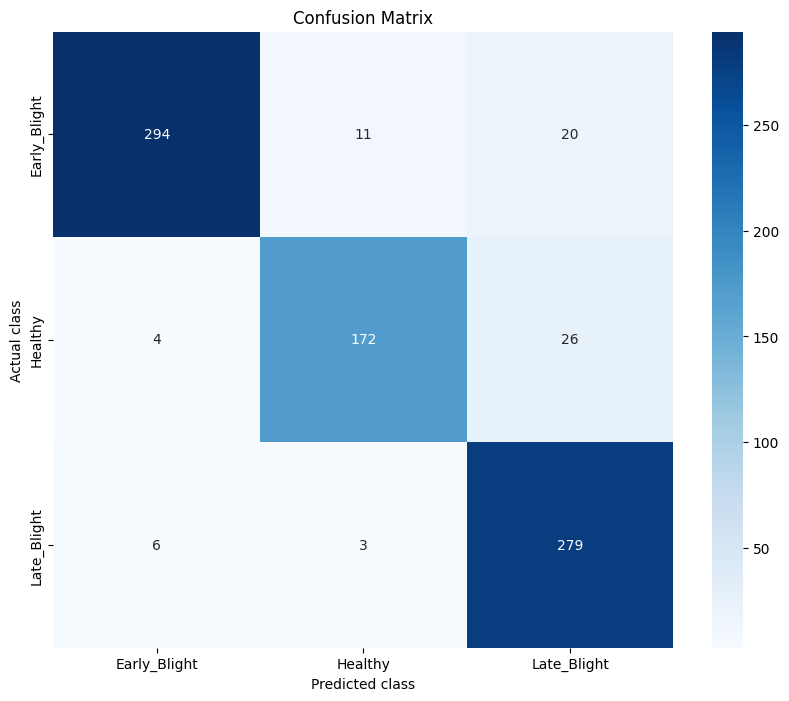

Classification report:
              precision    recall  f1-score   support

Early_Blight       0.97      0.90      0.93       325
     Healthy       0.92      0.85      0.89       202
 Late_Blight       0.86      0.97      0.91       288

    accuracy                           0.91       815
   macro avg       0.92      0.91      0.91       815
weighted avg       0.92      0.91      0.91       815



In [ ]:
# Initialize lists for storing images and tags
all_images = []
all_labels = []

# Iterate through all generator batches.
for i in range(len(test_generator)):
    images_test, labels_test = next(test_generator) # Get a batch.
    images_validation, labels_validation = next(validation_generator) # Get a batch
    all_images.append(images_test) # Add images from batch
    all_labels.append(labels_test) # Add labels from batch
    all_images.append(images_validation) # Add images from batch
    all_labels.append(labels_validation) # Add labels from the batch

# Convert lists to arrays
all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

# Make predictions
predictions = model_InceptionV3.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Convert probabilities to predicted labels
true_labels_classes = np.argmax(all_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels_classes, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion Matrix')
plt.show()

# Sort report
print('Classification report:')
print(classification_report(true_labels_classes, predicted_labels, target_names=class_names))